In [5]:
import os
import json
import random
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights


SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE} ({torch.cuda.get_device_name(0) if DEVICE.type == 'cuda' else 'CPU'})")

Device: cuda (Tesla T4)


In [6]:
DATA_DIR = Path("/kaggle/input/dog-breed-classification/DATASET")
TRAIN_DIR, TEST_DIR = DATA_DIR / "train_images", DATA_DIR / "test_images"

train_df = pd.read_csv(DATA_DIR / "train_data.csv")
test_df = pd.read_csv(DATA_DIR / "test_data.csv")

print("Train_df:", train_df.shape)
print("Test_df:", test_df.shape)
print(train_df.head())

Train_df: (10222, 2)
Test_df: (9600, 2)
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [7]:
files = {p.stem for p in TRAIN_DIR.glob("*.jpg")}.union({p.stem for p in TEST_DIR.glob("*.jpg")})
ids = set(train_df["id"].values).union(test_df["id"].values)

print(f"Всего изображений: {len(files)}")
print(f"Отсутствует:       {len(ids - files)} id в папке")
print(f"Лишних файлов:     {len(files - ids)}")
print(" Уникальных пород:", train_df["breed"].nunique())

print("\n Пустые значения (NaN):")
print("Test_df:")
print(test_df.isnull().sum())
print("Train_df:")
print(train_df.isnull().sum())

Всего изображений: 19822
Отсутствует:       0 id в папке
Лишних файлов:     0
 Уникальных пород: 120

 Пустые значения (NaN):
Test_df:
id       0
breed    0
dtype: int64
Train_df:
id       0
breed    0
dtype: int64


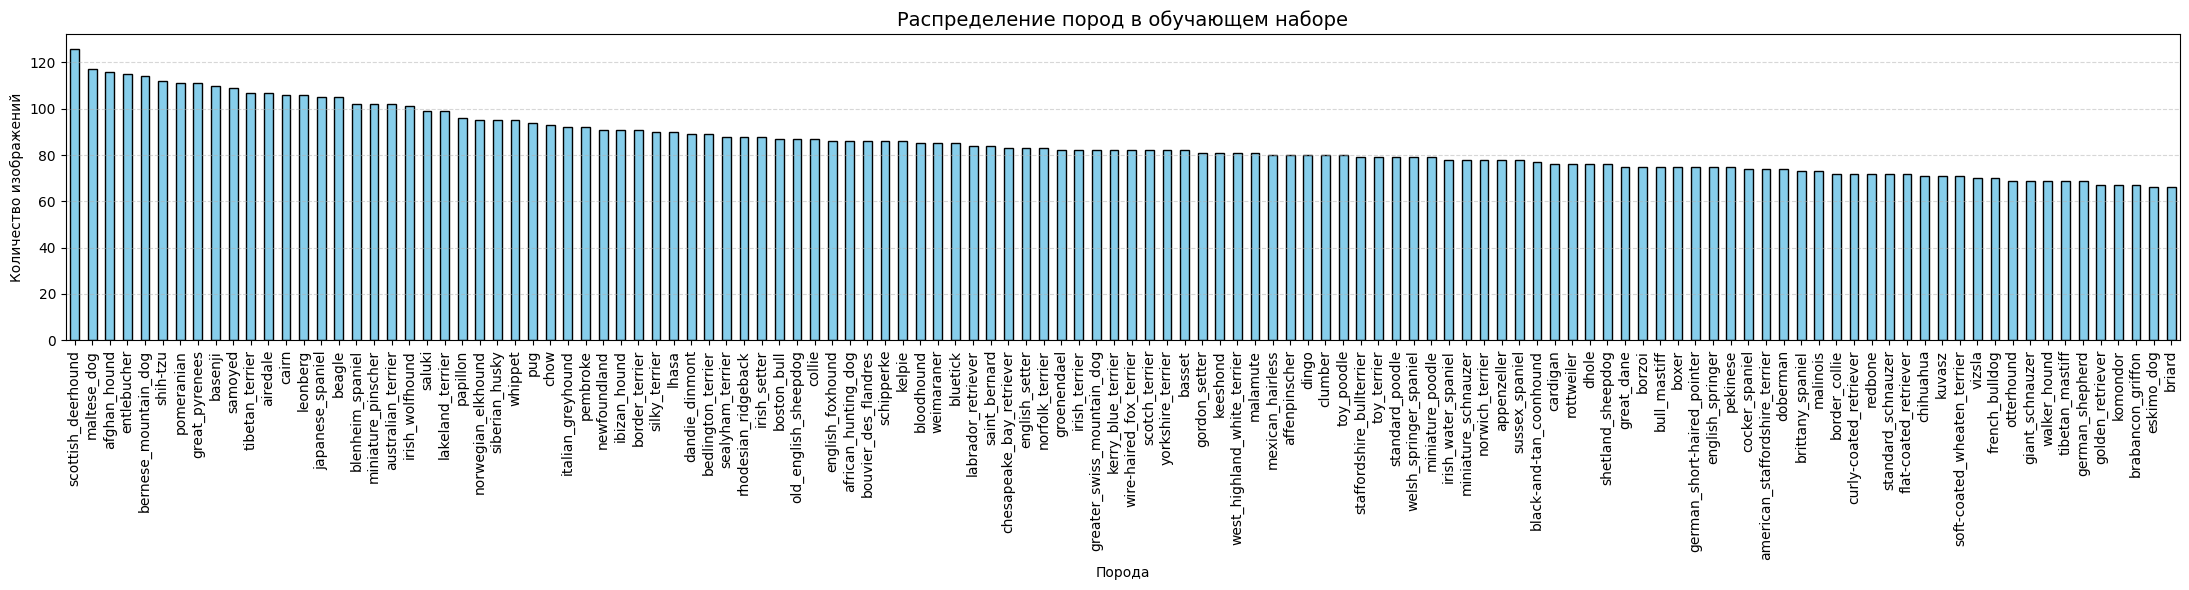

In [8]:

plt.figure(figsize=(22, 6))
train_df["breed"].value_counts().plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Распределение пород в обучающем наборе", fontsize=14)
plt.xlabel("Порода")
plt.ylabel("Количество изображений")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [9]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
train_idx, val_idx = next(skf.split(train_df, train_df["breed"]))

train_df_split = train_df.iloc[train_idx].reset_index(drop=True)
val_df_split   = train_df.iloc[val_idx].reset_index(drop=True)

breeds = sorted(train_df["breed"].unique())
breed2idx = {b: i for i, b in enumerate(breeds)}
idx2breed = {i: b for b, i in breed2idx.items()}

train_df_split["label"] = train_df_split["breed"].map(breed2idx)
val_df_split["label"]   = val_df_split["breed"].map(breed2idx)

out_path = Path("/kaggle/working/breeds.json")
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(idx2breed, f, ensure_ascii=False, indent=2)

In [10]:
IMG_SIZE = 256    
BATCH_SIZE = 32
NUM_WORKERS = 0

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

class DogBreedDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["image_path"] if "image_path" in row else None

        if not img_path:
            img_path = TRAIN_DIR / f"{row['id']}.jpg"

        img = Image.open(img_path).convert("RGB")
        label = int(row["label"])

        if self.transform:
            img = self.transform(img)
        return img, label
        
train_ds = DogBreedDataset(train_df_split, transform=train_transforms)
val_ds   = DogBreedDataset(val_df_split, transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=NUM_WORKERS)

print("DataLoaders готовы")
print(f"Train: {len(train_ds)}, val: {len(val_ds)}")

DataLoaders готовы
Train: 8177, val: 2045


In [11]:
weights_path = "/kaggle/input/rwightman/keras/default/1/efficientnet_b0_rwightman-7f5810bc.pth"
NUM_CLASSES = len(breeds)

model = efficientnet_b0(weights=None)

state_dict = torch.load(weights_path, map_location=DEVICE)
model.load_state_dict(state_dict, strict=False)

in_feats = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_feats, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)

print("EfficientNet готова")

EfficientNet готова


In [12]:
def accuracy_top1(output, target):
    _, pred = output.max(1)
    correct = (pred == target).sum().item()
    return correct / target.size(0) * 100

EPOCHS = 12
best_val_acc = 0.0
MODEL_PATH = Path("/kaggle/working/dog_breed_efficientnet.pt")

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss, train_acc, total = 0.0, 0.0, 0

    for imgs, labels in tqdm(train_loader, desc=f"Train {epoch:02d}", leave=False):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        acc = accuracy_top1(outputs, labels)
        train_loss += loss.item() * imgs.size(0)
        train_acc  += acc * imgs.size(0)
        total += imgs.size(0)

    train_loss /= total
    train_acc  /= total

    model.eval()
    val_loss, val_acc, total_val = 0.0, 0.0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            acc = accuracy_top1(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            val_acc  += acc * imgs.size(0)
            total_val += imgs.size(0)

    if total_val > 0:
        val_loss /= total_val
        val_acc  /= total_val
    else:
        val_loss, val_acc = 0, 0

    print(f"# Epoch {epoch:02d}/{EPOCHS} | "
          f"train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | "
          f"train_acc={train_acc:.2f}% | val_acc={val_acc:.2f}%")

    scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"+ Лучшая модель сохранена (val_acc={val_acc:.2f}%)")

print(f"Обучение завершено. Лучшая точность: {best_val_acc:.2f}%")


Train 01:   0%|          | 0/256 [00:00<?, ?it/s]

# Epoch 01/12 | train_loss=3.8372 | val_loss=2.2996 | train_acc=24.14% | val_acc=54.96%
+ Лучшая модель сохранена (val_acc=54.96%)


Train 02:   0%|          | 0/256 [00:00<?, ?it/s]

# Epoch 02/12 | train_loss=1.8970 | val_loss=1.2111 | train_acc=58.77% | val_acc=70.61%
+ Лучшая модель сохранена (val_acc=70.61%)


Train 03:   0%|          | 0/256 [00:00<?, ?it/s]

# Epoch 03/12 | train_loss=1.2342 | val_loss=0.9207 | train_acc=71.53% | val_acc=75.65%
+ Лучшая модель сохранена (val_acc=75.65%)


Train 04:   0%|          | 0/256 [00:00<?, ?it/s]

# Epoch 04/12 | train_loss=0.9889 | val_loss=0.8032 | train_acc=75.31% | val_acc=77.46%
+ Лучшая модель сохранена (val_acc=77.46%)


Train 05:   0%|          | 0/256 [00:00<?, ?it/s]

# Epoch 05/12 | train_loss=0.8407 | val_loss=0.7404 | train_acc=78.76% | val_acc=78.63%
+ Лучшая модель сохранена (val_acc=78.63%)


Train 06:   0%|          | 0/256 [00:00<?, ?it/s]

# Epoch 06/12 | train_loss=0.7164 | val_loss=0.7220 | train_acc=82.24% | val_acc=78.78%
+ Лучшая модель сохранена (val_acc=78.78%)


Train 07:   0%|          | 0/256 [00:00<?, ?it/s]

# Epoch 07/12 | train_loss=0.6437 | val_loss=0.6926 | train_acc=83.82% | val_acc=79.32%
+ Лучшая модель сохранена (val_acc=79.32%)


Train 08:   0%|          | 0/256 [00:00<?, ?it/s]

# Epoch 08/12 | train_loss=0.5929 | val_loss=0.6863 | train_acc=84.77% | val_acc=79.51%
+ Лучшая модель сохранена (val_acc=79.51%)


Train 09:   0%|          | 0/256 [00:00<?, ?it/s]

# Epoch 09/12 | train_loss=0.5494 | val_loss=0.6708 | train_acc=86.19% | val_acc=79.46%


Train 10:   0%|          | 0/256 [00:00<?, ?it/s]

# Epoch 10/12 | train_loss=0.5214 | val_loss=0.6512 | train_acc=87.16% | val_acc=80.24%
+ Лучшая модель сохранена (val_acc=80.24%)


Train 11:   0%|          | 0/256 [00:00<?, ?it/s]

# Epoch 11/12 | train_loss=0.4880 | val_loss=0.6523 | train_acc=87.88% | val_acc=80.05%


Train 12:   0%|          | 0/256 [00:00<?, ?it/s]

# Epoch 12/12 | train_loss=0.4639 | val_loss=0.6507 | train_acc=88.93% | val_acc=80.34%
+ Лучшая модель сохранена (val_acc=80.34%)
Обучение завершено. Лучшая точность: 80.34%


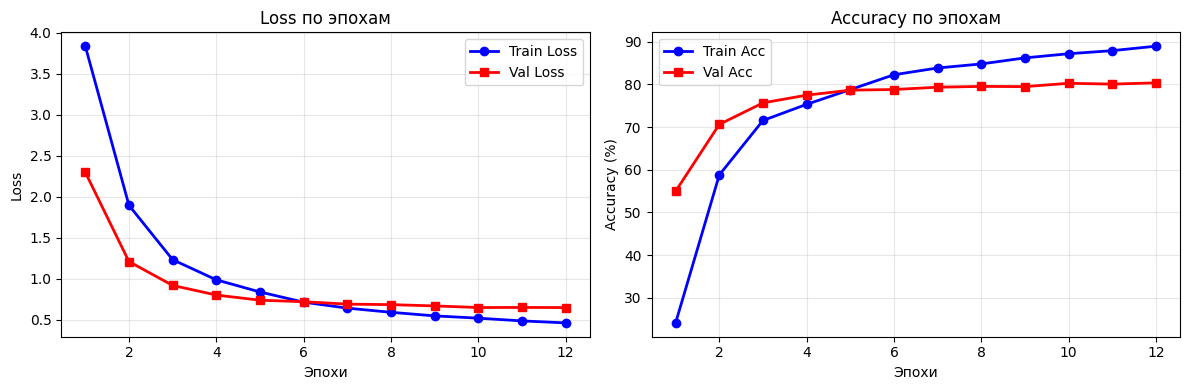

In [14]:
epochs = list(range(1, 13))
train_loss = [3.8372, 1.8970, 1.2342, 0.9889, 0.8407, 0.7164, 0.6437, 0.5929, 0.5494, 0.5214, 0.4880, 0.4639]
val_loss = [2.2996, 1.2111, 0.9207, 0.8032, 0.7404, 0.7220, 0.6926, 0.6863, 0.6708, 0.6512, 0.6523, 0.6507]
train_acc = [24.14, 58.77, 71.53, 75.31, 78.76, 82.24, 83.82, 84.77, 86.19, 87.16, 87.88, 88.93]
val_acc = [54.96, 70.61, 75.65, 77.46, 78.63, 78.78, 79.32, 79.51, 79.46, 80.24, 80.05, 80.34]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Train Loss', linewidth=2, marker='o')
plt.plot(epochs, val_loss, 'r-', label='Val Loss', linewidth=2, marker='s')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.title('Loss по эпохам')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Train Acc', linewidth=2, marker='o')
plt.plot(epochs, val_acc, 'r-', label='Val Acc', linewidth=2, marker='s')
plt.xlabel('Эпохи')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy по эпохам')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class TestDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx]['id']
        img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, img_id

test_dataset = TestDataset(test_df, TEST_DIR, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=NUM_WORKERS)


In [ ]:
model.eval()
test_predictions = []
test_ids = []

with torch.no_grad():
    for images, img_ids in tqdm(test_loader, desc="Тестирование"):
        images = images.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        test_predictions.extend(predicted.cpu().numpy())
        test_ids.extend(img_ids)

test_breeds = [idx2breed[pred] for pred in test_predictions]

submission_df = pd.DataFrame({
    'id': test_ids,
    'breed': test_breeds
})

submission_df.to_csv('submission.csv', index=False)
print("Submission file saved!")
print(submission_df.head())

plt.figure(figsize=(22, 6))
submission_df['breed'].value_counts().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Распределение предсказанных пород в тестовой выборке', fontsize=14)
plt.xlabel('Порода')
plt.ylabel('Количество изображений')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Тестирование:   0%|          | 0/150 [00:00<?, ?it/s]